# BRAIN Cancer - PCA on all features - Classification

In [1]:
#Import packages
import pandas as pd
import numpy as np

#import xgboost
from xgboost import XGBClassifier, plot_importance

#import sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate 
from sklearn.metrics import *
from sklearn import metrics

import shap

import os

import  warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Preprocessing of data 

We load the PCA results file on the BRAIN data, then classify the data with XGBoost.

### Load data and declare feature vector and target variable

In [2]:
df=pd.read_csv("/Users/justine_labory/Desktop/github/plantnet/Metabolomic_project/brain_project/data/BRAIN_PCA.csv")
X=df.drop("Label", axis=1)
y=df["Label"]

In [3]:
X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
0,-49.572347,13.336220,34.732191,11.334620,-43.413725,14.211304,-42.997616,14.505900,-4.548479,54.445563,...,6.088567,2.941133,-5.172268,-1.269866,2.980947,0.096115,1.440753,0.502286,0.364551,-0.525967
1,-47.044249,42.073326,1.315488,-50.305856,-13.114318,2.324225,-2.076168,8.305738,-8.016241,31.175392,...,-4.138273,-0.482195,12.689384,-6.632427,-12.449379,-6.411548,-3.138007,1.039486,1.123832,-2.824270
2,-37.672043,22.320641,41.289398,-21.643959,-24.355535,-12.854332,8.792402,14.292597,-18.329025,20.886355,...,-6.042581,-5.429264,-11.437309,14.280099,9.199323,13.789941,-3.451295,3.187195,-2.376293,3.516910
3,32.816246,38.934716,38.944051,-63.385157,-27.105304,35.117100,15.279924,17.862353,-9.078108,2.532406,...,7.109571,-2.700843,0.875972,-5.416215,0.099380,-0.579538,3.045744,-0.789216,2.890062,1.283159
4,-31.330006,39.015475,-38.957510,-13.081205,-23.881903,0.584113,8.644065,-13.616099,-12.078717,13.171594,...,-4.479059,4.841559,5.003006,-8.379390,-4.445375,-13.136649,-1.993917,5.491365,-0.552051,0.918926


In [4]:
y.head()

0    1
1    1
2    1
3    1
4    0
Name: Label, dtype: int64

### Run XGBoost model with cross validation

[[ 4  5]
 [ 3 10]]
0.6363636363636364
0.6068376068376069
0.7142857142857142
0.6666666666666666
0.7692307692307693
0.6153846153846154


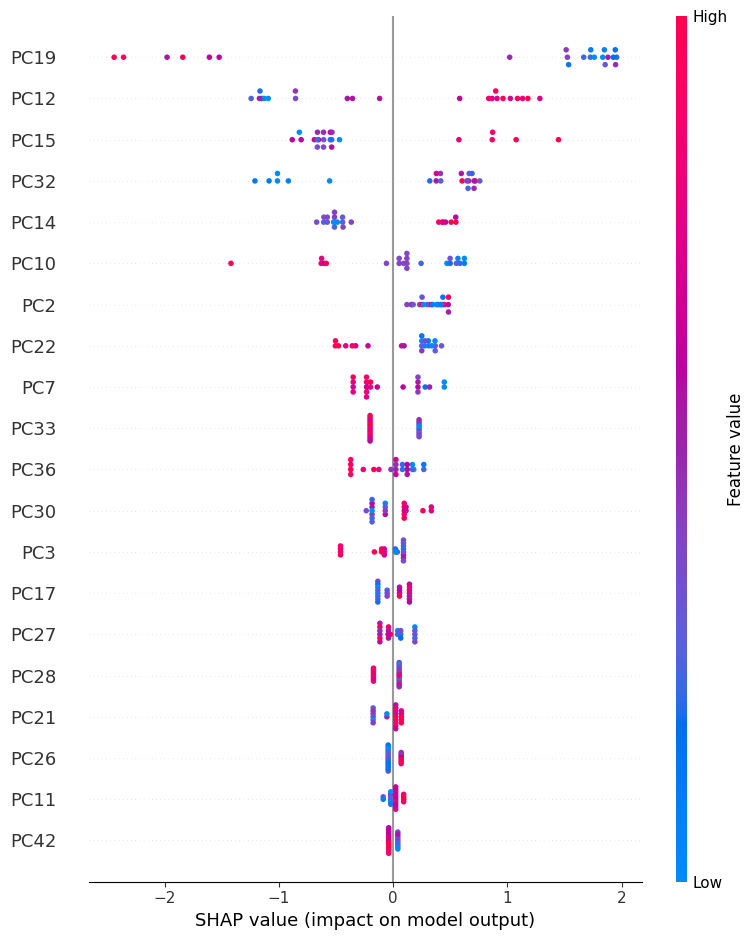

[[ 7  2]
 [ 3 10]]
0.7727272727272727
0.7735042735042735
0.8
0.8333333333333334
0.7692307692307693
0.8803418803418803


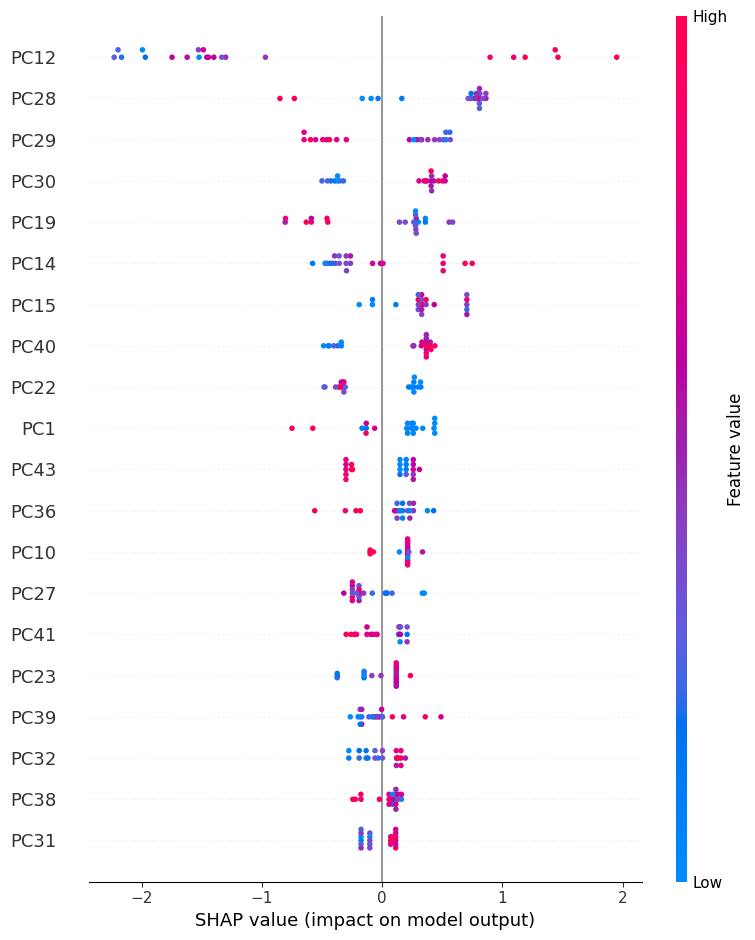

[[4 6]
 [4 8]]
0.5454545454545454
0.5333333333333333
0.6153846153846153
0.5714285714285714
0.6666666666666666
0.6083333333333334


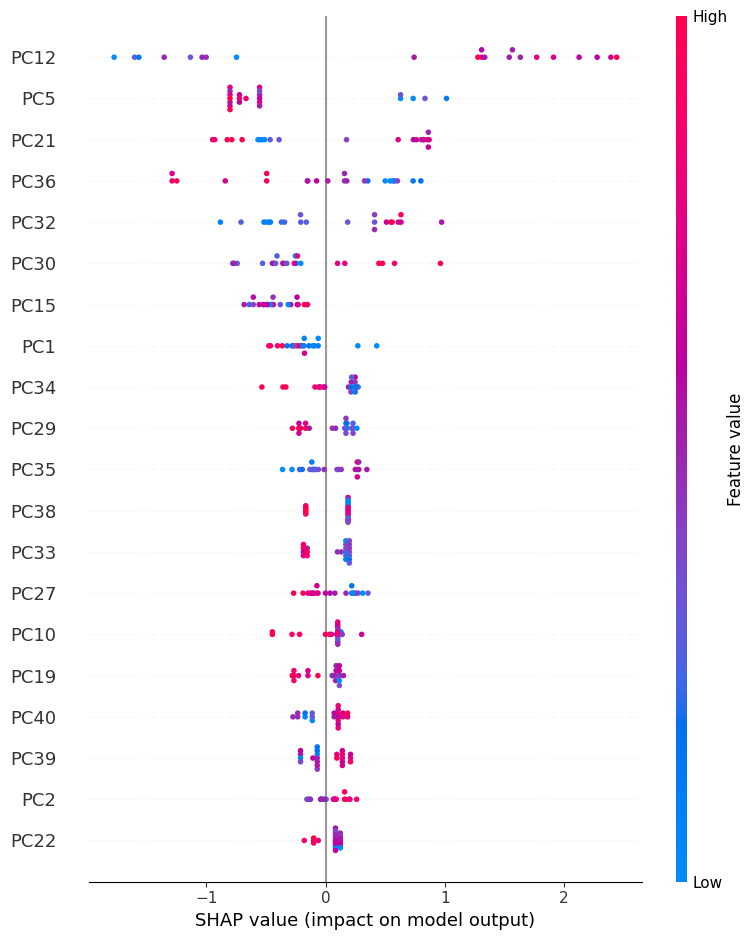

[[ 4  6]
 [ 2 10]]
0.6363636363636364
0.6166666666666667
0.7142857142857143
0.625
0.8333333333333334
0.6166666666666667


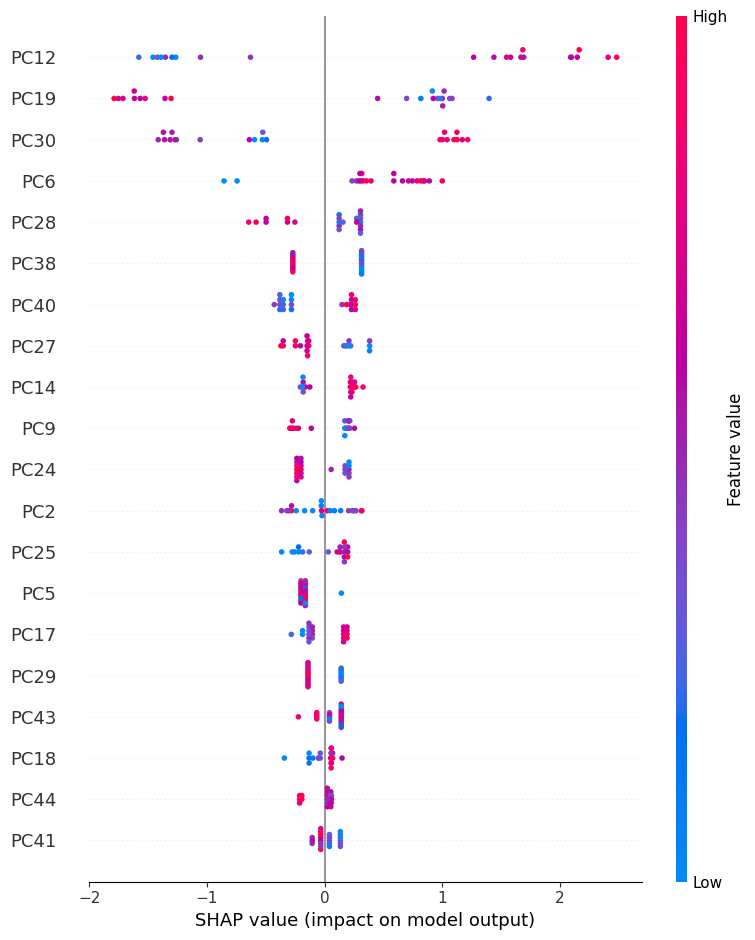

In [5]:
kfold = StratifiedKFold(n_splits=4)

lst_df = []

df_metrics = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1score',
                                   'roc_auc', 'specificity'],
                         index = ['fold1', 'fold2', 'fold3', 'fold4'])

cnt_fold = 1

for train_index,test_index in kfold.split(X,y):
    
    X_train=X.iloc[train_index]
    y_train=y.iloc[train_index]
    X_test=X.iloc[test_index]
    y_test=y.iloc[test_index]


    xgboost = XGBClassifier(seed=1234)

    xgboost = xgboost.fit(X_train,y_train)
    y_pred_proba = xgboost.predict_proba(X_test)[:,1]
    # # Get predicted probability
    y_pred = xgboost.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1score = metrics.f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    spe= tn / (tn + fp)
    
    # Fill in the dataframe with metrics
    df_metrics.iloc[(cnt_fold -1)] = [acc, bal_acc, f1score, precision, recall, roc_auc, spe]
    
    print(acc)
    print(bal_acc)
    print(f1score)
    print(precision)
    print(recall)
    print(roc_auc)

#     Add feature importance with SHAP

    explainer = shap.TreeExplainer(xgboost)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

    cnt_fold+=1

## Compute mean and standard deviation of metrics

In [6]:
print(f'The mean accuracy is: {np.mean(df_metrics["accuracy"])*100:.1f} (±{np.std(df_metrics["accuracy"])*100:.1f}) ')
print(f'The mean balanced accuracy is: {np.mean(df_metrics["balanced_accuracy"])*100:.1f} (±{np.std(df_metrics["balanced_accuracy"])*100:.1f}) ')
print(f'The mean precision is: {np.mean(df_metrics["precision"])*100:.1f} (±{np.std(df_metrics["precision"])*100:.1f}) ')
print(f'The mean recall is: {np.mean(df_metrics["recall"])*100:.1f} (±{np.std(df_metrics["recall"])*100:.1f}) ')
print(f'The mean F1 score is: {np.mean(df_metrics["f1score"])*100:.1f} (±{np.std(df_metrics["f1score"])*100:.1f}) ')
print(f'The mean ROC AUC is: {np.mean(df_metrics["roc_auc"])*100:.1f} (±{np.std(df_metrics["roc_auc"])*100:.1f}) ')
print(f'The mean specificity is: {np.mean(df_metrics["specificity"])*100:.1f} (±{np.std(df_metrics["specificity"])*100:.1f}) ')

The mean accuracy is: 64.8 (±8.1) 
The mean balanced accuracy is: 63.3 (±8.8) 
The mean precision is: 71.1 (±6.5) 
The mean recall is: 67.4 (±9.8) 
The mean F1 score is: 76.0 (±6.0) 
The mean ROC AUC is: 68.0 (±11.6) 
The mean specificity is: 50.6 (±15.8) 


## Compute 95% CI

In [7]:
acc_ci= np.percentile(df_metrics["accuracy"], [2.5,97.5])
bal_acc_ci= np.percentile(df_metrics["balanced_accuracy"], [2.5,97.5])
precision_ci = np.percentile(df_metrics["precision"], [2.5,97.5])
recall_ci= np.percentile(df_metrics["recall"], [2.5,97.5])
f1_ci = np.percentile(df_metrics["f1score"], [2.5,97.5])
roc_auc_ci = np.percentile(df_metrics["roc_auc"], [2.5,97.5])
specificity_ci = np.percentile(df_metrics['specificity'], [2.5,97.5])

print(f'The confidence interval for accuracy is [{acc_ci[0]*100:.1f} ; {acc_ci[1]*100:.1f}]')
print(f'The confidence interval for balanced accucary is [{bal_acc_ci[0]*100:.1f} ; {bal_acc_ci[1]*100:.1f}]')
print(f'The confidence interval for precision is [{precision_ci[0]*100:.1f} ; {precision_ci[1]*100:.1f}]')
print(f'The confidence interval for recall is [{recall_ci[0]*100:.1f} ; {recall_ci[1]*100:.1f}]')
print(f'The confidence interval for F1 score is [{f1_ci[0]*100:.1f} ; {f1_ci[1]*100:.1f}]')
print(f'The confidence interval for ROC AUC score is [{roc_auc_ci[0]*100:.1f} ; {roc_auc_ci[1]*100:.1f}]')
print(f'The confidence interval for specificity score is [{specificity_ci[0]*100:.1f} ; {specificity_ci[1]*100:.1f}]')

The confidence interval for accuracy is [55.2 ; 76.2]
The confidence interval for balanced accucary is [53.9 ; 76.2]
The confidence interval for precision is [62.3 ; 79.4]
The confidence interval for recall is [57.5 ; 82.1]
The confidence interval for F1 score is [67.4 ; 82.9]
The confidence interval for ROC AUC score is [60.9 ; 86.1]
The confidence interval for specificity score is [40.0 ; 75.3]
